In [1]:
import xarray as xr
from evaluations.confusion_table import  compute_score, plot_confusion_table, compute_all_scores
from products.plot_settings import METEOFRANCE_VAR_NAME,NASA_L3_VAR_NAME,NASA_PSEUDO_L3_VAR_NAME,PRODUCT_PLOT_NAMES
from winter_year import WinterYear

wy = WinterYear(2023,2024)
analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_4/analyses/confusion_table'
nasa_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_l3_res_375m.nc", decode_cf=True)
mf_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_meteofrance_l3_res_375m.nc", decode_cf=True)
nasa_pseudo_l3_metrics_ds = xr.open_dataset(f"{analysis_folder}/confusion_table_WY_2023_2024_SNPP_nasa_pseudo_l3_res_375m.nc", decode_cf=True)
analyses_dict = {METEOFRANCE_VAR_NAME: mf_metrics_ds, NASA_PSEUDO_L3_VAR_NAME: nasa_pseudo_l3_metrics_ds, NASA_L3_VAR_NAME: nasa_l3_metrics_ds}

In [2]:
from typing import Dict
import numpy as np
import pandas as pd
import seaborn as sns
from evaluations.statistics_base import EvaluationVsHighResBase
import matplotlib.pyplot as plt


def plot_multiple_confusion_table(metrics_dict: Dict[str, xr.Dataset], title_complement: str):
    n_prods = len(metrics_dict)
    fig, axs = plt.subplots(ncols=n_prods, figsize=( 6*n_prods,5))
    fig.suptitle("Confusion table comparison - " + title_complement + '\n')
    for i, (product, metrics_ds) in enumerate(metrics_dict.items()):
        accuracy = compute_score(metrics_ds, 'accuracy').values
        plot_confusion_table(metrics_ds,axes=axs[i])
        axs[i].set_title(f'{PRODUCT_PLOT_NAMES[product]} - accuracy = {accuracy:.2f}')



def plot_multiple_scores_sns(metrics_dict: Dict[str, xr.Dataset],variable: str, xlabel:str,title_complement: str):
    results = []
    for  metrics_ds in metrics_dict.values():
        results.append(metrics_ds.groupby(variable).map(compute_all_scores))
    results = xr.concat(results, pd.Index(list(metrics_dict.keys()), name="product")).to_dataframe()
    results = results.reset_index([variable, 'product'])
    results = results.melt(id_vars=['product', variable], var_name='score', value_name='value')
    sns.set_style("darkgrid")
    g = sns.relplot(results,x=variable,hue="score",y='value',col='product', kind='line',style='score',markers=True, col_wrap=np.min([len(metrics_dict),4]))
    g.figure.suptitle(f"Performance Metrics vs {title_complement}", fontsize=14, fontweight="bold")
    # Adjust layout to make space for the title
    g.figure.subplots_adjust(top=0.85)
    g.set_axis_labels(xlabel, "Score [-]")


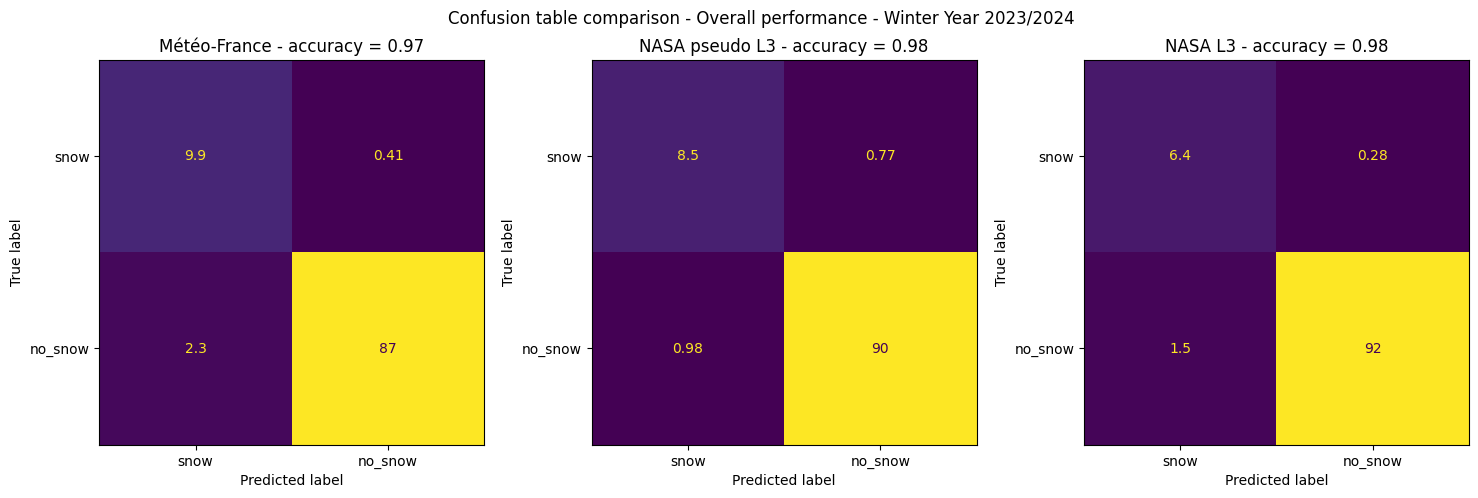

In [3]:
plot_multiple_confusion_table(metrics_dict=analyses_dict, title_complement=f"Overall performance - {str(wy)}")

percentage wrt to original domain 55.11346111478299
percentage wrt to original domain 54.815841358605596
percentage wrt to original domain 55.78317238520739


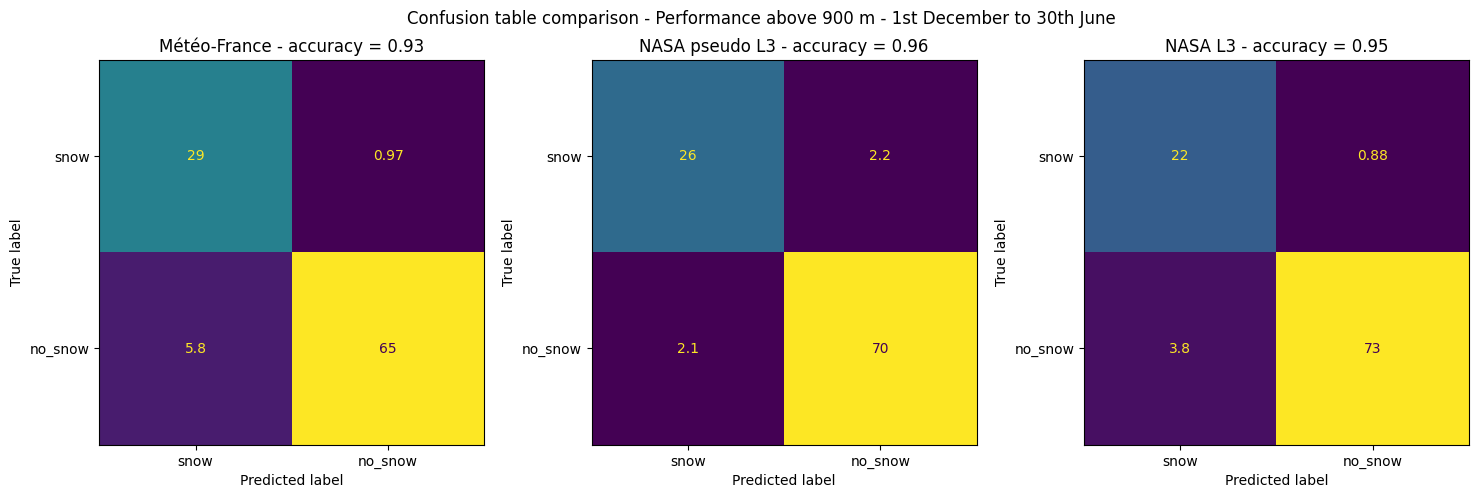

In [ ]:
# Altitude selection to change if altitude bins are intended to the left edge of the bin
selection_dict = {k: v.sel(time=slice('2023-12','2024-06')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
for k, v in selection_dict.items():
    # data_vars selection doesn't matter
    print(f"percentage wrt to original domain for product {k}", v.data_vars['true_positive'].count().values/analyses_dict[k].data_vars['true_positive'].count().values*100)
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement=f'Performance above 900 m - 1st December to 30th June - {str(wy)}')

percentage wrt to original domain for product meteofrance_l3 26.187939815714785
percentage wrt to original domain for product nasa_pseudo_l3 25.370256365751725
percentage wrt to original domain for product nasa_l3 25.502074457273356


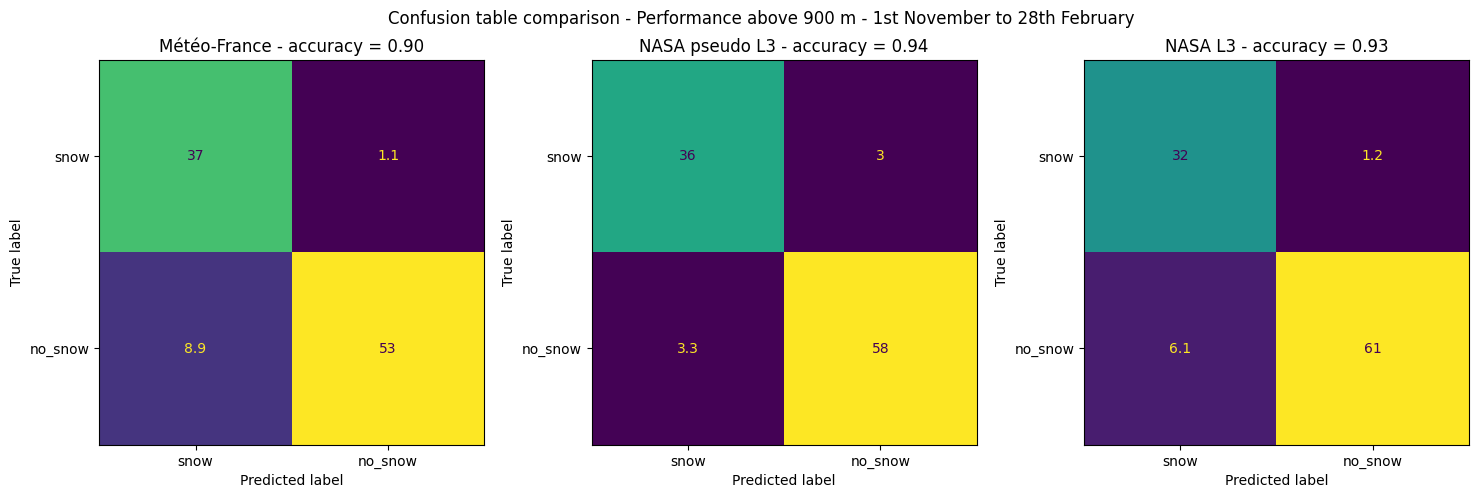

In [ ]:
# Altitude selection to change if altitude bins are intended to the left edge of the bin
selection_dict = {k: v.sel(time=slice('2023-12','2024-02')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
for k, v in selection_dict.items():
    # data_vars selection doesn't matter
    print(f"percentage wrt to original domain for product {k}", v.data_vars['true_positive'].count().values/analyses_dict[k].data_vars['true_positive'].count().values*100)
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement=f'Performance above 900 m - 1st November to 28th February - {str(wy)}')

percentage wrt to original domain for product meteofrance_l3 21.570441792050595
percentage wrt to original domain for product nasa_pseudo_l3 22.724153922507192
percentage wrt to original domain for product nasa_l3 24.10515366128756


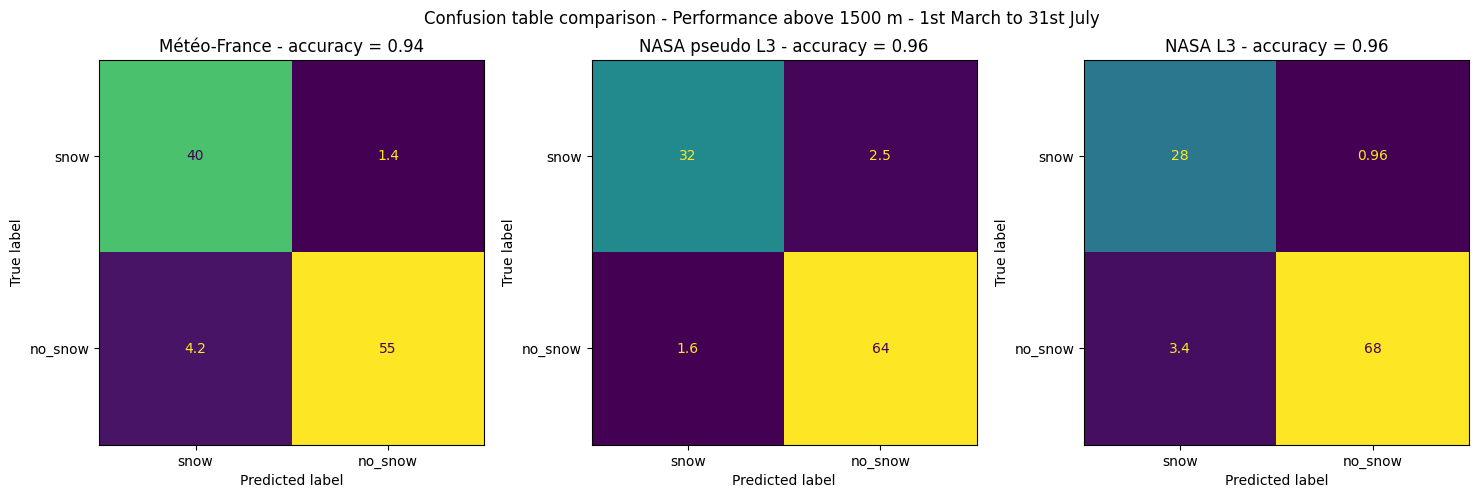

In [ ]:
# Altitude selection to change if altitude bins are intended to the left edge of the bin
selection_dict = {k: v.sel(time=slice('2024-03','2024-07')).sel(altitude_bins=slice(2100,None)) for k,v in analyses_dict.items()}
for k, v in selection_dict.items():
    # data_vars selection doesn't matter
    print(f"percentage wrt to original domain for product {k}", v.data_vars['true_positive'].count().values/analyses_dict[k].data_vars['true_positive'].count().values*100)
plot_multiple_confusion_table(metrics_dict=selection_dict, title_complement=f'Performance above 1500 m - 1st March to 31st July- {str(wy)}')

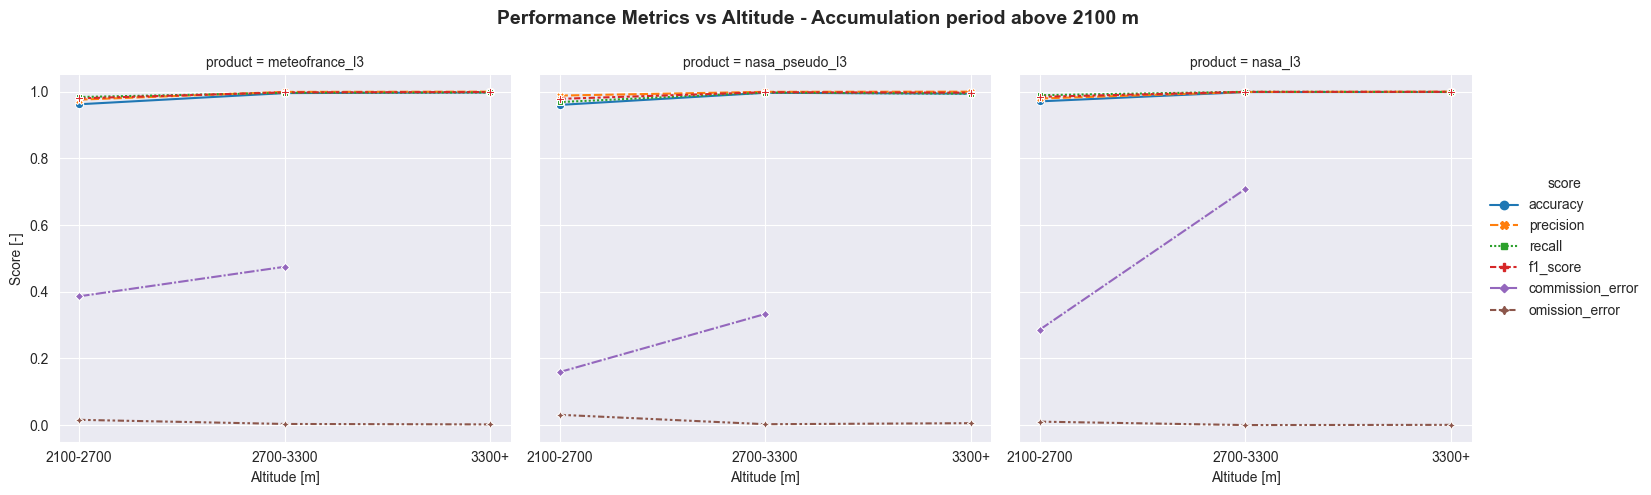

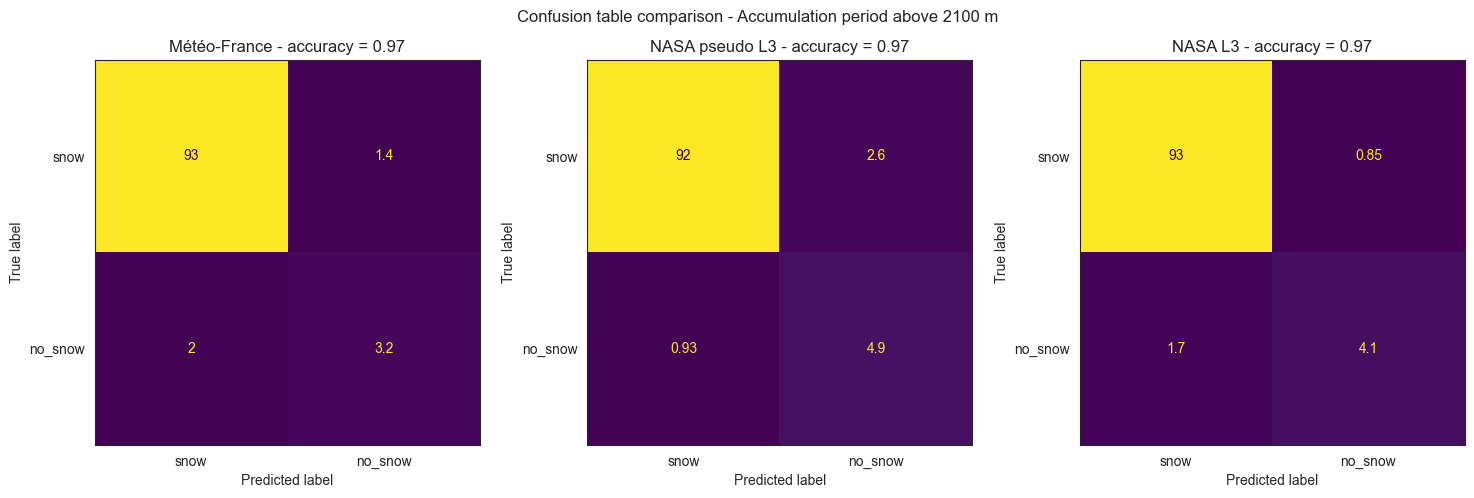

In [ ]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-02')).sel(altitude_bins=slice(2700, None)) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'altitude_bins': pd.CategoricalIndex(data=['2100-2700','2700-3300', '3300+'], categories=['2100-2700','2700-3300', '3300+'], ordered=True)}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='altitude_bins', xlabel='Altitude [m]',title_complement=f'Altitude - Accumulation period above 2100 m - {str(wy)}')
sns.set_style("white")
plot_multiple_confusion_table(selection_dict, f'Accumulation period above 2100 m - {str(wy)}')

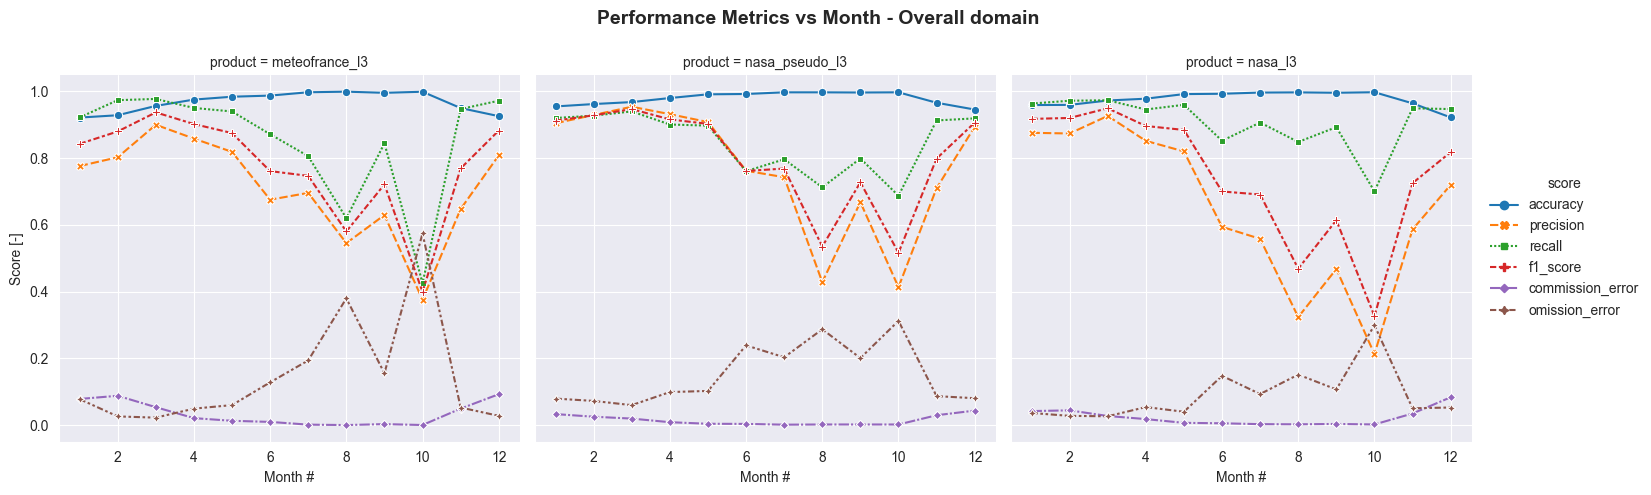

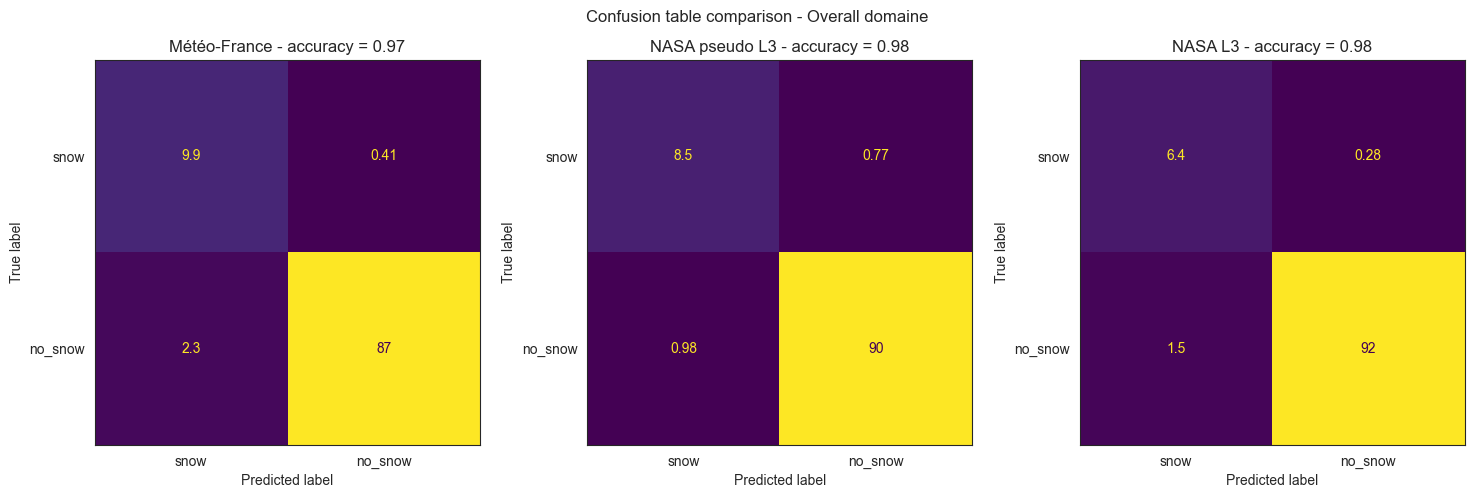

In [ ]:
selection_dict = {k: v for k,v in analyses_dict.items()}

def plot_multiple_scores_sns_month(metrics_dict: Dict[str, xr.Dataset],variable: str, xlabel:str,title_complement: str):
    results = []
    for  metrics_ds in metrics_dict.values():
        results.append(metrics_ds.groupby(variable).map(compute_all_scores))
    results = xr.concat(results, pd.Index(list(metrics_dict.keys()), name="product")).to_dataframe()
    results = results.reset_index([variable[-5:], 'product'])
    results = results.melt(id_vars=['product', variable[-5:]], var_name='score', value_name='value')
    sns.set_style("darkgrid")
    g = sns.relplot(results,x=variable[-5:],hue="score",y='value',col='product', kind='line',style='score',markers=True, col_wrap=np.min([len(metrics_dict),4]))
    g.figure.suptitle(f"Performance Metrics vs {title_complement}", fontsize=14, fontweight="bold")
    # Adjust layout to make space for the title
    g.figure.subplots_adjust(top=0.85)
    g.set_axis_labels(xlabel, "Score [-]")


plot_multiple_scores_sns_month(metrics_dict=selection_dict, variable='time.month', xlabel='Month #',title_complement=f'Month - Overall domain - {str(wy)}')
sns.set_style("white")
plot_multiple_confusion_table(selection_dict, f'Overall domain - {str(wy)}')

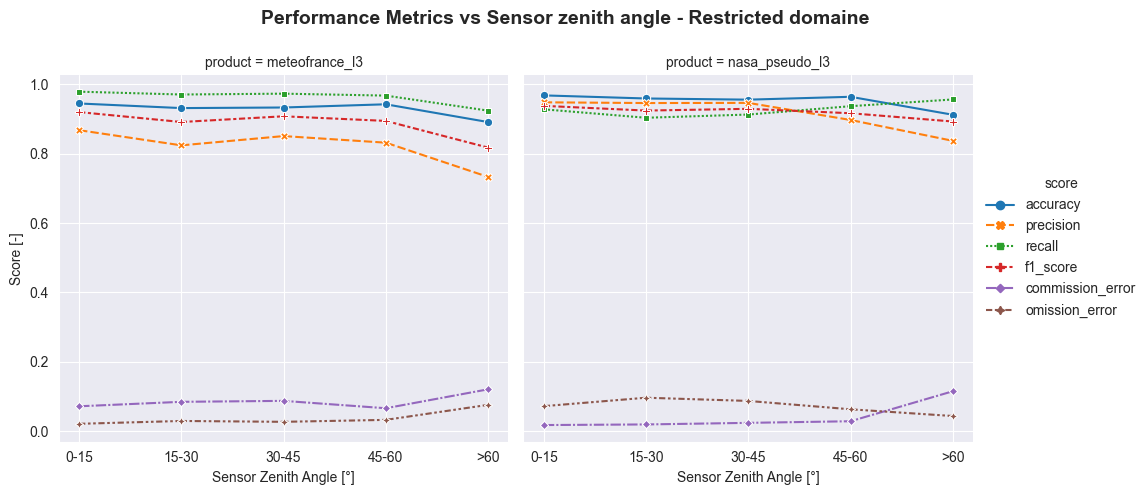

In [ ]:
selection_dict = {k: v.sel(altitude_bins=slice(1500,None)).sel(time=slice('2023-12','2024-06')) for k,v in analyses_dict.items()}
selection_dict.pop('nasa_l3')
selection_dict = {k: v.sel(sensor_zenith_bins=slice(None, 75)).assign_coords({'sensor_zenith_bins': ['0-15', '15-30', '30-45', '45-60', '>60']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='sensor_zenith_bins', xlabel='Sensor Zenith Angle [°]',title_complement=f'Sensor zenith angle - Restricted domain- {str(wy)}')

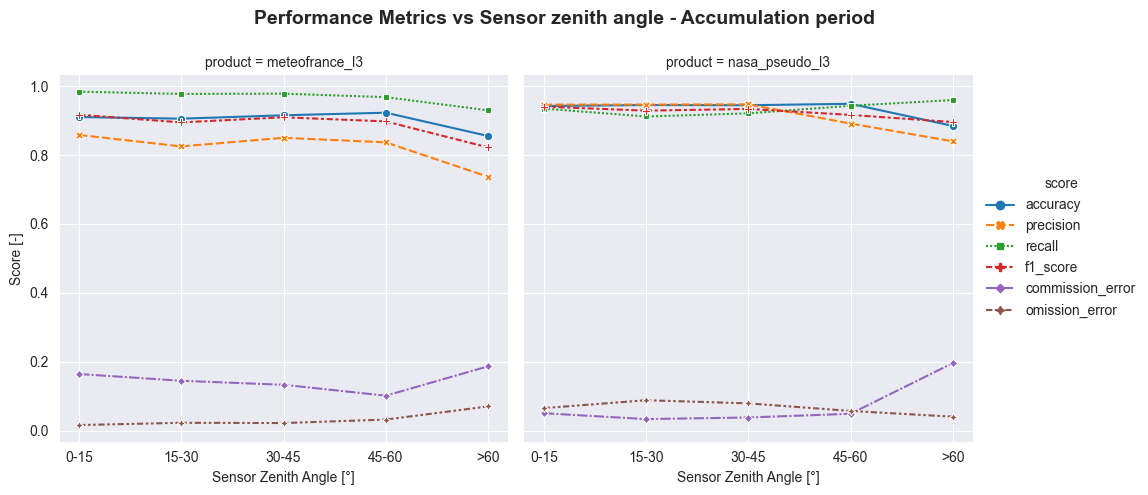

In [ ]:
selection_dict = {k: v.sel(altitude_bins=slice(1500,None)).sel(time=slice('2023-12','2024-03')) for k,v in analyses_dict.items()}
selection_dict.pop('nasa_l3')
selection_dict = {k: v.sel(sensor_zenith_bins=slice(None, 75)).assign_coords({'sensor_zenith_bins': ['0-15', '15-30', '30-45', '45-60', '>60']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='sensor_zenith_bins', xlabel='Sensor Zenith Angle [°]',title_complement=f'Sensor zenith angle - Accumulation period - {str(wy)}')

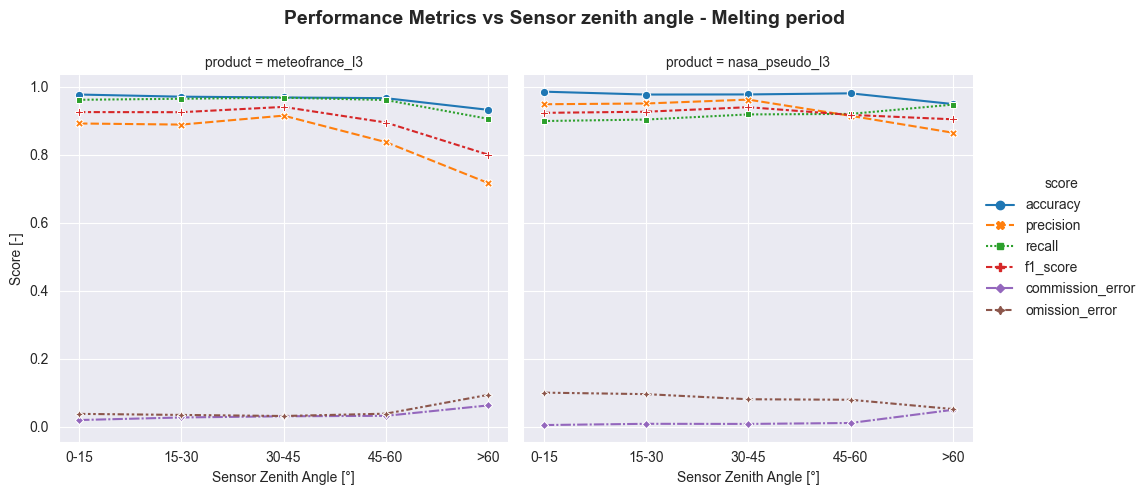

In [ ]:
selection_dict = {k: v.sel(altitude_bins=slice(1500,None)).sel(time=slice('2024-03','2024-07')) for k,v in analyses_dict.items()}
selection_dict.pop('nasa_l3')
selection_dict = {k: v.sel(sensor_zenith_bins=slice(None, 75)).assign_coords({'sensor_zenith_bins': ['0-15', '15-30', '30-45', '45-60', '>60']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='sensor_zenith_bins', xlabel='Sensor Zenith Angle [°]',title_complement=f'Sensor zenith angle - Melting period - {str(wy)}')

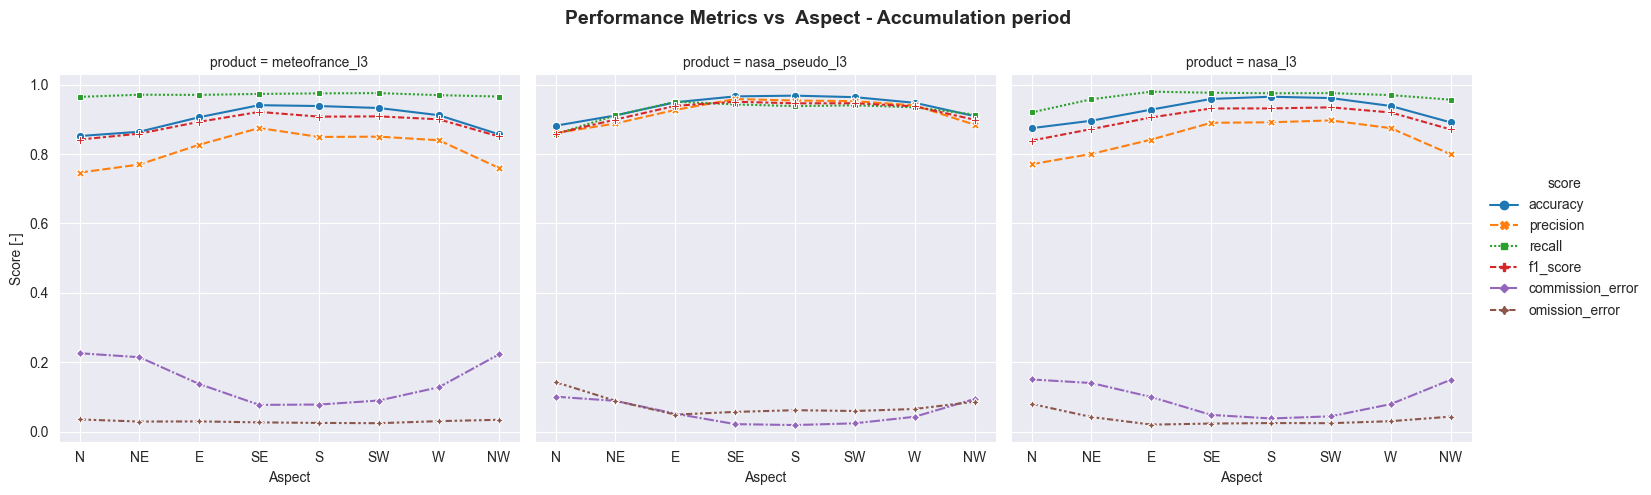

In [ ]:
from evaluations.statistics_base import EvaluationVsHighResBase
selection_dict = {k: v.sel(time=slice('2023-12','2024-02')).sel(altitude_bins=slice(1500, None)) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'aspect_bins':pd.CategoricalIndex(data=EvaluationVsHighResBase.aspect_bins().labels, categories=EvaluationVsHighResBase.aspect_bins().labels, ordered=True)}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='aspect_bins', xlabel='Aspect',title_complement=f'Aspect - Accumulation period- {str(wy)}')


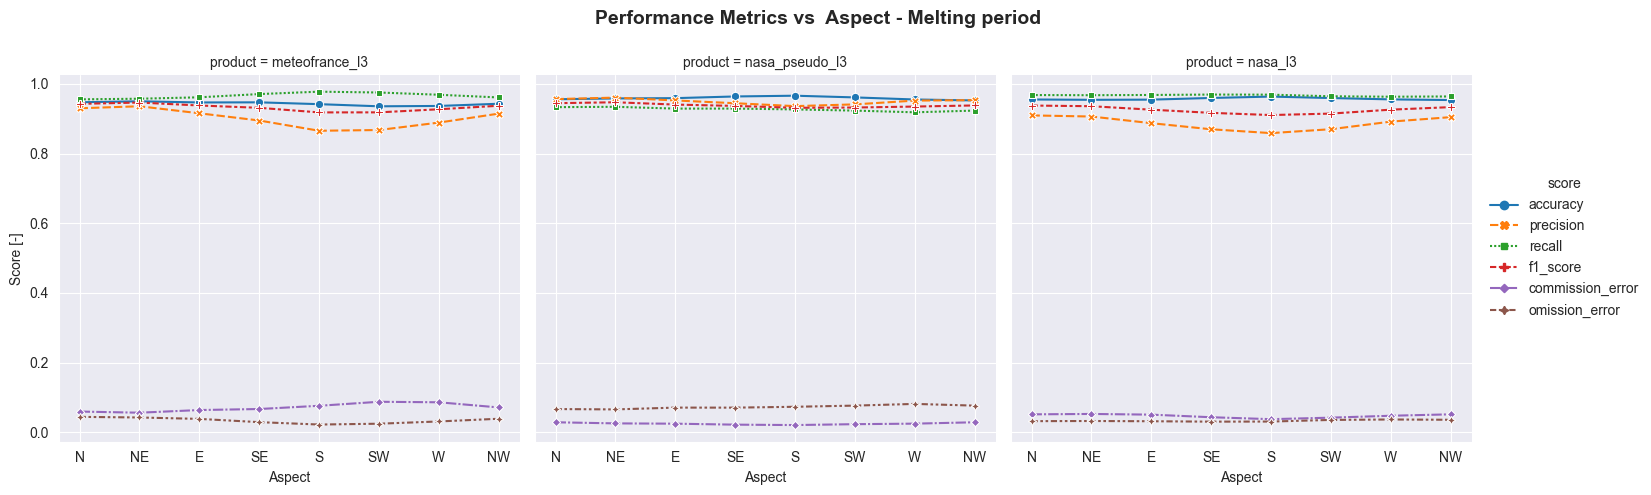

In [ ]:
from evaluations.statistics_base import EvaluationVsHighResBase
selection_dict = {k: v.sel(time=slice('2024-03','2024-07')).sel(altitude_bins=slice(2100, None)) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'aspect_bins':pd.CategoricalIndex(data=EvaluationVsHighResBase.aspect_bins().labels, categories=EvaluationVsHighResBase.aspect_bins().labels, ordered=True)}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='aspect_bins', xlabel='Aspect',title_complement=f'Aspect - Melting period - {str(wy)}')


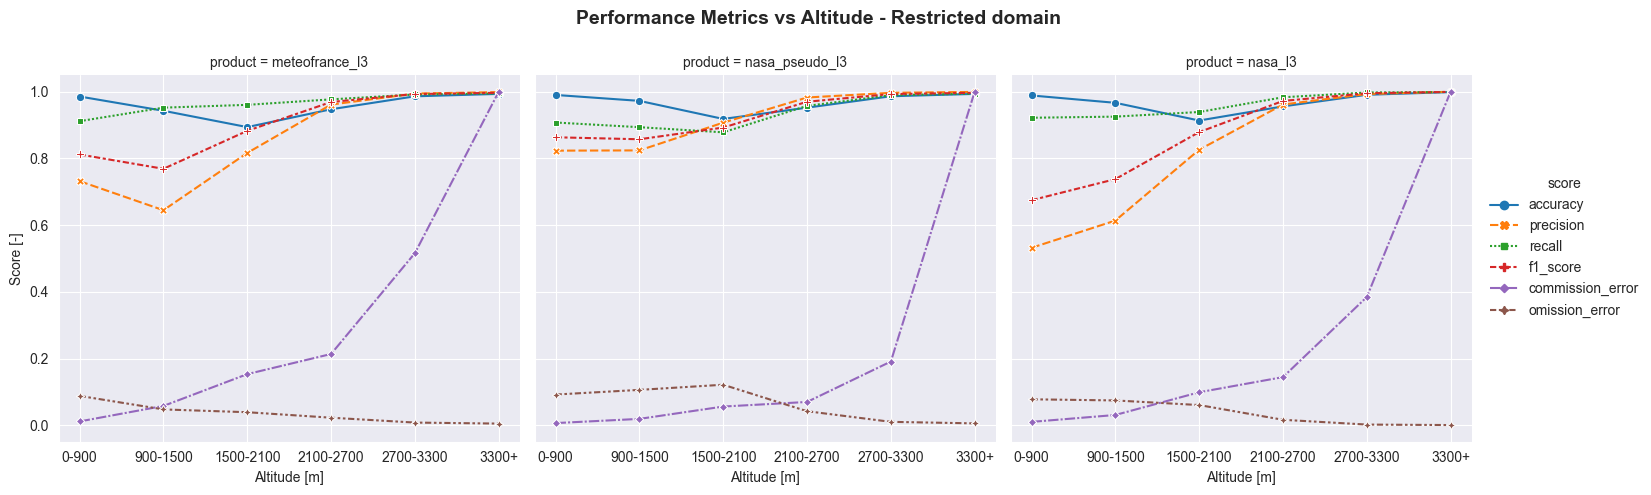

In [ ]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-06')) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'altitude_bins': pd.CategoricalIndex(data=['0-900', '900-1500','1500-2100','2100-2700','2700-3300', '3300+'], categories=['0-900', '900-1500','1500-2100','2100-2700','2700-3300', '3300+'], ordered=True)}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='altitude_bins', xlabel='Altitude [m]',title_complement=f'Altitude - Restricted domain- {str(wy)}')


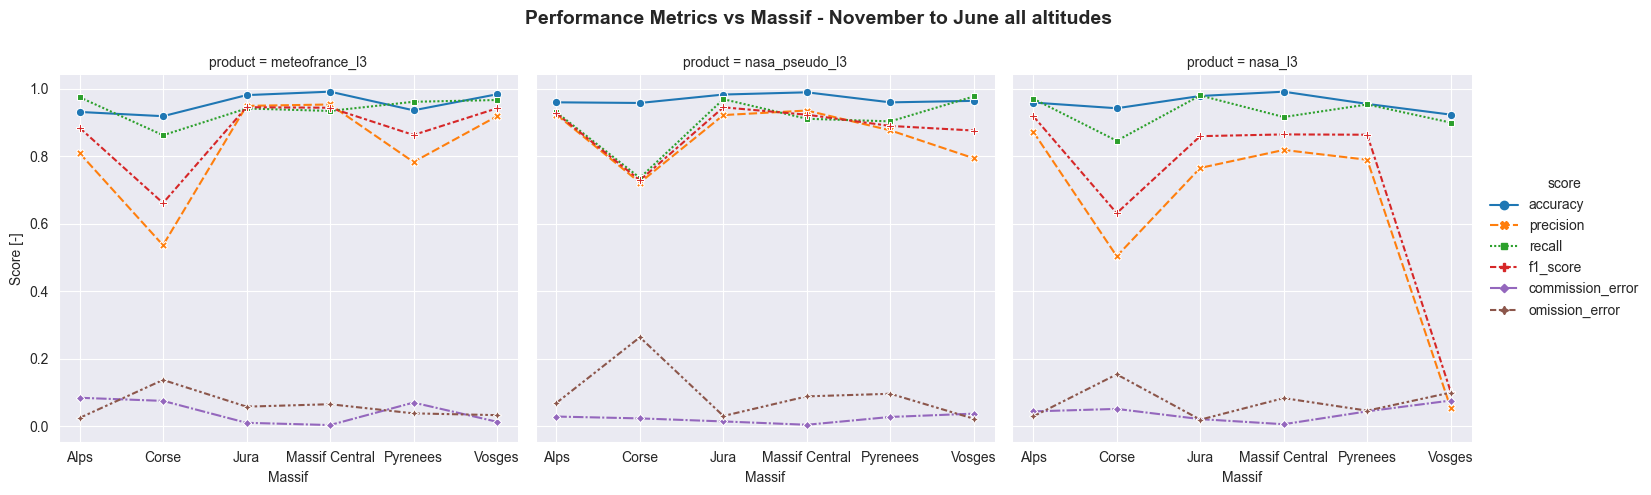

In [ ]:
from evaluations.statistics_base import EvaluationVsHighResBase
selection_dict = {k: v.sel(time=slice('2023-11', '2024-06')) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'sub_roi': ['','Alps', 'Pyrenees', 'Corse', 'Massif Central', 'Jura', 'Vosges']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='sub_roi', xlabel='Massif',title_complement=f'Massif - November to June all altitudes - {str(wy)}')


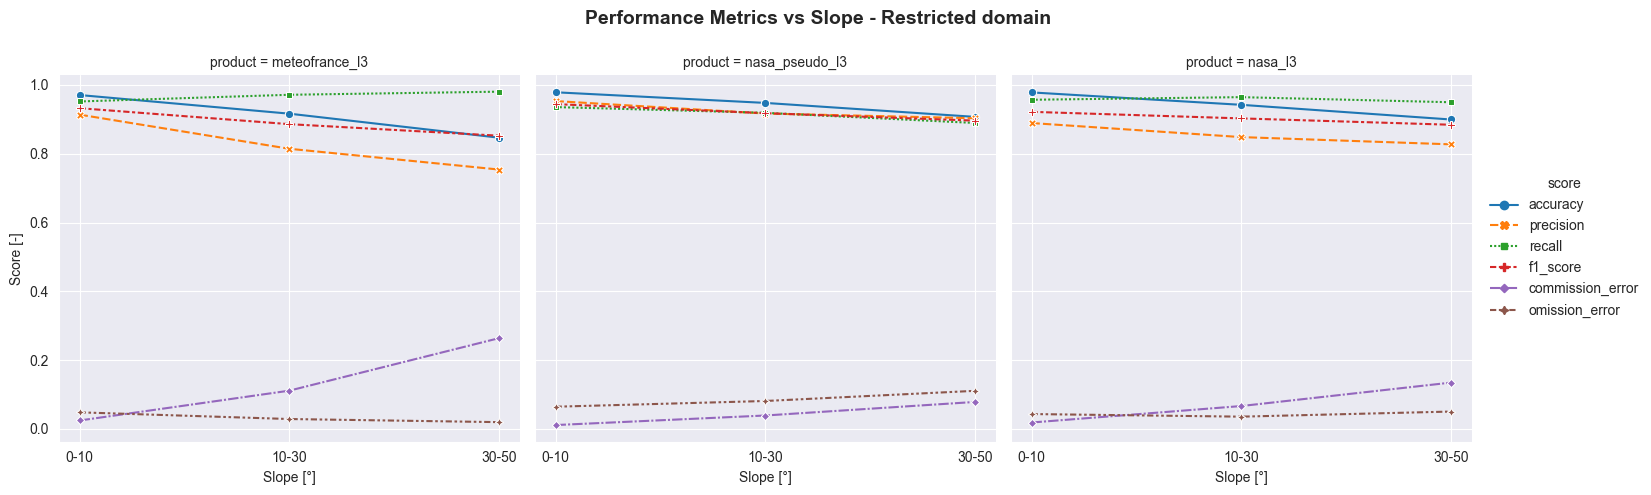

In [ ]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-06')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
selection_dict = {k: v.sel(slope_bins=slice(None, 50)).assign_coords({'slope_bins': ['0-10', '10-30', '30-50']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='slope_bins', xlabel='Slope [°]',title_complement=f'Slope - Restricted domain - {str(wy)}')


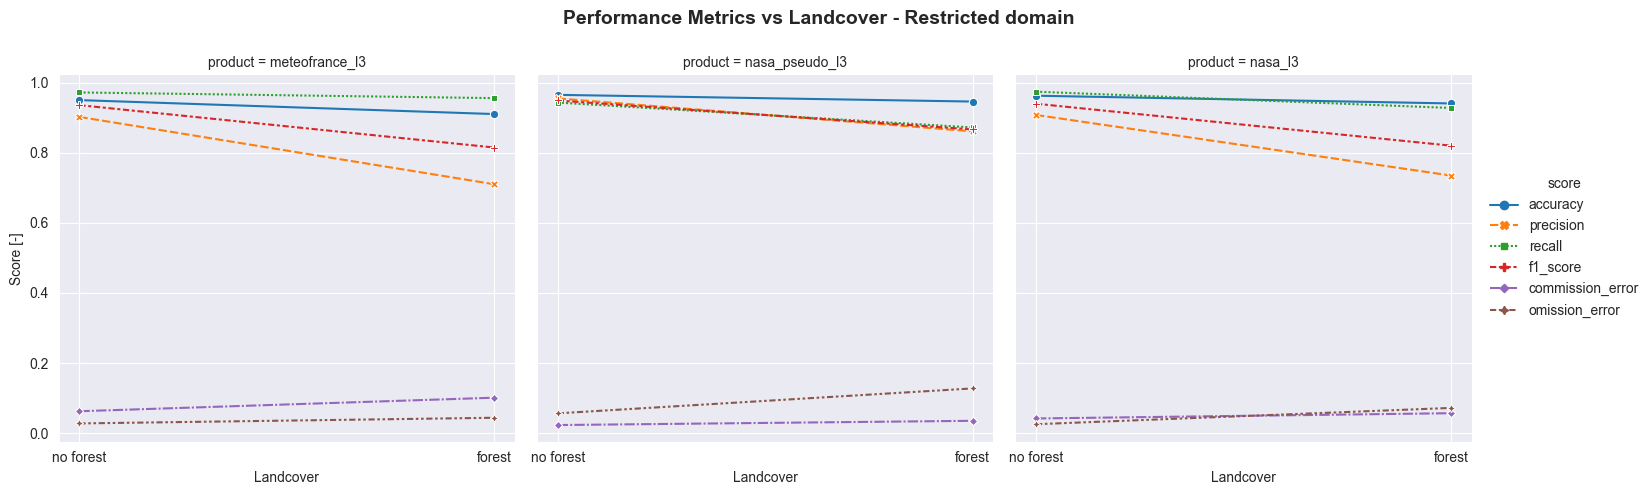

In [ ]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-06')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
selection_dict = {k: v.assign_coords({'forest_mask': ['no forest', 'forest']}) for k,v in selection_dict.items()}
plot_multiple_scores_sns(metrics_dict=selection_dict, variable='forest_mask', xlabel='Landcover',title_complement=f'Landcover - Restricted domain - {str(wy)}')

In [4]:
import pandas as pd
def compute_results_df(metrics_dict: xr.Dataset)-> pd.DataFrame:
    results = []
    for  metrics_ds in metrics_dict.values():
        results.append(compute_all_scores(metrics_ds))
    results = xr.concat(results, pd.Index(list(selection_dict.keys()), name="product")).to_dataframe()
    results = results.reset_index(['product'])
    return pd.DataFrame(results)

def fancy_table(results_df: pd.DataFrame):
    color_maps = {
        "accuracy": "RdYlGn",  
        "precision": "RdYlGn",
        "recall": "RdYlGn",
        "f1_score": "RdYlGn",
        "commission_error": "RdYlGn_r",  # Lower is better 
        "omission_error": "RdYlGn_r"
    }
    vmins = {
        "accuracy": 0.8,  # Higher is better
        "precision": 0.6,
        "recall": 0.6,
        "f1_score": 0.6,
        "commission_error": 0,  # Lower is better (reversed Reds)
        "omission_error": 0
    }
    vmaxs = {
        "accuracy": 1,  # Higher is better
        "precision": 1,
        "recall": 1,
        "f1_score": 1,
        "commission_error": 0.3,  # Lower is better 
        "omission_error": 0.2
    }

    # Apply gradient coloring
    styled_df = results_df.style

    def highlight_product(val):
        return "background-color: mediumblue; color: white; font-weight: bold; text-align: center"

    styled_df = styled_df.map(highlight_product, subset=["product"])

    for col, cmap in color_maps.items():
        if col in results_df.columns:
            styled_df = styled_df.background_gradient(subset=[col], cmap=cmap,vmin=vmins[col],vmax=vmaxs[col])

    styled_df = styled_df.set_properties(**{"text-align": "center"})  # Center-align all text
    styled_df = styled_df.set_table_styles(
        [{"selector": "th", "props": [("background-color", "darkblue"), ("color", "white"), ("font-weight", "bold")]}]
    )

    return styled_df.hide(level=None)

In [182]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-06')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("General performance")
fancy_table(df)

General performance


product,accuracy,precision,recall,f1_score,commission_error,omission_error
meteofrance_l3,0.932364,0.831969,0.967276,0.894535,0.082353,0.032724
nasa_pseudo_l3,0.957030,0.924788,0.920876,0.922828,0.028980,0.079124
nasa_l3,0.953458,0.854895,0.961859,0.905228,0.049067,0.038141


In [ ]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-02')).sel(aspect_bins=['NE','N','NW']).sel(slope_bins=slice(30,None)).sel(forest_mask=1).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("Worst case scenario: accumulation period, north slopes >10°, forest")
fancy_table(df)

Worst case scenario: accumulation period, north slopes >10°, forest


product,accuracy,precision,recall,f1_score,commission_error,omission_error,forest_mask
meteofrance_l3,0.753132,0.583496,0.970092,0.728693,0.359509,0.029908,1.000000
nasa_pseudo_l3,0.839934,0.777893,0.784298,0.781082,0.128212,0.215702,1.000000
nasa_l3,0.829727,0.669995,0.891579,0.765066,0.198187,0.108421,1.000000


In [213]:
selection_dict = {k: v.sel(time=slice('2023-12', '2024-02')).sel(altitude_bins=slice(1500,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("General accumulation scenario: accumulation period, all slopes")
fancy_table(df)

General accumulation scenario: accumulation period, all slopes


product,accuracy,precision,recall,f1_score,commission_error,omission_error
meteofrance_l3,0.899993,0.808381,0.970508,0.882056,0.144210,0.029492
nasa_pseudo_l3,0.937176,0.916772,0.922084,0.919420,0.053228,0.077916
nasa_l3,0.926969,0.839116,0.962988,0.896795,0.090731,0.037012


In [214]:
selection_dict = {k: v.sel(time=slice('2024-03', '2024-07')).sel(altitude_bins=slice(2100,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("General ablation scenario: ablation period, all slopes")
fancy_table(df)

General ablation scenario: ablation period, all slopes


product,accuracy,precision,recall,f1_score,commission_error,omission_error
meteofrance_l3,0.943346,0.903322,0.964990,0.933138,0.071674,0.035010
nasa_pseudo_l3,0.958765,0.950778,0.927293,0.938889,0.024907,0.072707
nasa_l3,0.956790,0.891014,0.966424,0.927188,0.047044,0.033576


In [8]:
selection_dict = {k: v.sel(time=slice('2024-03', '2024-07')).sel(aspect_bins=['SE','S','SW']).sel(slope_bins=slice(None,40)).sel(forest_mask=0).sel(altitude_bins=slice(2100,None)) for k,v in analyses_dict.items()}
df = compute_results_df(selection_dict)
print("Best case scenario: ablation period, south slopes <30°, no forest")
fancy_table(df)

Best case scenario: ablation period, south slopes <30°, no forest


product,accuracy,precision,recall,f1_score,commission_error,omission_error,forest_mask
meteofrance_l3,0.953471,0.909652,0.975919,0.941621,0.060553,0.024081,0.000000
nasa_pseudo_l3,0.968892,0.958863,0.934214,0.946378,0.016678,0.065786,0.000000
nasa_l3,0.965390,0.891039,0.971899,0.929714,0.036615,0.028101,0.000000
